# Supplementary Materials
## Inference calculations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cellfate import model, io, celldensity
import emcee
import scipy.optimize as op
import imp

First, let's create the bins with different size

In [2]:
bin_2x2 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 2)
bin_4x4 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 4)
bin_6x6 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 6)
bin_8x8 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 8)
bin_10x10 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 10)
bin_12x12 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 12)

Followings are the functions to help our analysis.

In [3]:
def plot_chain(sampler, coupled, nwalkers=10):
    '''
    Plots the traces of walkers from MCMC run.
    
    Arguments:
        sampler: Ensemble sampler from emcee package which underwent MCMC run
        coupled: True if we use model with diffusion. False if we use model without diffusion.
        nwalkers: number of walkers to plot
    '''

    if coupled:
        fig, (ax_k_div, ax_k_bg, ax_k_br, ax_k_mov) = plt.subplots(4)
        ax_k_div.set(ylabel='k_div')
        ax_k_bg.set(ylabel='k_bg')
        ax_k_br.set(ylabel='k_br')
        ax_k_mov.set(ylabel='k_mov')
        for i in range(nwalkers):
            sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
            sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
            sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)
            sns.tsplot(sampler.chain[i,:,3], ax=ax_k_mov)
    else:
        fig, (ax_k_div, ax_k_bg, ax_k_br) = plt.subplots(3)
        ax_k_div.set(ylabel='k_div')
        ax_k_bg.set(ylabel='k_bg')
        ax_k_br.set(ylabel='k_br')
        for i in range(nwalkers):
            sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
            sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
            sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)    

In [4]:
def plot_kdes(sampler, coupled, burntime=300):
    '''
    Plots joint kde plots of parameters estimated from the MCMC run.
    Returns the list of median values of estimated parameters from their respective distributions.
    
    Arguments:
        sampler: Ensemble sampler from emcee package which underwent MCMC run
        coupled: True if we use model with diffusion. False if we use model without diffusion.
        burntime: Burn-in time of MCMC run
    '''    
    samples = sampler.chain[:,burntime:,:]
    
    if coupled:
        ndim = 4
        # reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
        traces = samples.reshape(-1, ndim).T

        # Create a pandas DataFrame with labels.
        parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 
                                          'k_br': traces[2], 'k_mov': traces[3]})

        # Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
        g = sns.PairGrid(parameter_samples)
        g.map_diag(sns.kdeplot)
        g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);        

        k = [parameter_samples['k_div'].median(), parameter_samples['k_bg'].median(), \
             parameter_samples['k_br'].median(), parameter_samples['k_mov'].median()]
        print('k_div = %.5f' % (parameter_samples['k_div'].median()))
        print('k_bg = %.5f' % (parameter_samples['k_bg'].median()))
        print('k_br = %.5f' % (parameter_samples['k_br'].median()))        
        print('k_mov = %.5f' % (parameter_samples['k_mov'].median()))     
        
        return k
        
    else:
        ndim = 3
        # reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
        traces = samples.reshape(-1, ndim).T

        # Create a pandas DataFrame with labels.
        parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2]})

        # Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
        g = sns.PairGrid(parameter_samples)
        g.map_diag(sns.kdeplot)
        g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

        k = [parameter_samples['k_div'].median(), parameter_samples['k_bg'].median(), parameter_samples['k_br'].median()]
        print('k_div = %.5f' % (parameter_samples['k_div'].median()))
        print('k_bg = %.5f' % (parameter_samples['k_bg'].median()))
        print('k_br = %.5f' % (parameter_samples['k_br'].median()))        
        
        return k

In [5]:
def plot_heatmap(theta, data, coupled, plotNum=4):
    '''
    Plot the heatmap of each type of cell over time.
    
    Arguments:
        theta: a list of parameters for generative model
        data: Celldensity object containing experimental data
        coupled: True if we use model with diffusion. False if we use model without diffusion.
        plotNum : number of snapshots (plots). 
                  The time difference between each snapshot is even.    
    '''    

    dt = data.time_scale
    if coupled:
        # Heatmap for the actual data
        grid = data.pd2np()
        time_step = int(data.tot_time/plotNum)
        grn = grid[0,:,:,:] 
        red = grid[1,:,:,:]
        both = grid[2,:,:,:]

        plt.figure()
        plt.suptitle('Data')
        # Plot heatmap for each time i*time_step
        for i in range(plotNum):
            plt.subplot(plotNum,3,1+i*3)
            ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                        cmap="Greens", xticklabels=False, yticklabels=False)
            ax_g.invert_yaxis()

            plt.subplot(plotNum,3,2+i*3)
            ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                        cmap="Reds", xticklabels=False, yticklabels=False)
            ax_r.invert_yaxis()

            plt.subplot(plotNum,3,3+i*3)
            ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                        cmap="Oranges", xticklabels=False, yticklabels=False)
            ax_b.invert_yaxis()
            
            ax_g.set_title('Sox2 at t=%.1f' % (i*time_step*dt))
            ax_r.set_title('Oct4 at t=%.1f' % (i*time_step*dt))
            ax_b.set_title('Both at t=%.1f' % (i*time_step*dt))
            
        
        # Heatmap for the model
        grid = model.solver_coupled(theta, data)
        time_step = int(data.tot_time/plotNum)
        grn = grid[0,:,:,:] 
        red = grid[1,:,:,:]
        both = grid[2,:,:,:]

        plt.figure()
        plt.suptitle('Model')
        # Plot heatmap for each time i*time_step
        for i in range(plotNum):
            plt.subplot(plotNum,3,1+i*3)
            ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                        cmap="Greens", xticklabels=False, yticklabels=False)
            ax_g.invert_yaxis()

            plt.subplot(plotNum,3,2+i*3)
            ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=50,
                        cmap="Reds", xticklabels=False, yticklabels=False)
            ax_r.invert_yaxis()

            plt.subplot(plotNum,3,3+i*3)
            ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=50, 
                        cmap="Oranges", xticklabels=False, yticklabels=False)
            ax_b.invert_yaxis()

            ax_g.set_title('Sox2 at t=%.1f' % (i*time_step*dt))
            ax_r.set_title('Oct4 at t=%.1f' % (i*time_step*dt))
            ax_b.set_title('Both at t=%.1f' % (i*time_step*dt))
            

    else:
        # Heatmap for the actual data
        grid = data.pd2np()
        time_step = int(data.tot_time/plotNum)
        grn = grid[0,:,:,:] 
        red = grid[1,:,:,:]
        both = grid[2,:,:,:]

        plt.figure()
        plt.suptitle('Data')
        # Plot heatmap for each time i*time_step
        for i in range(plotNum):
            plt.subplot(plotNum,3,1+i*3)
            ax_g = sns.heatmap(grn[:,:,i*time_step], vmin=0, vmax=50,
                        cmap="Greens", xticklabels=False, yticklabels=False)
            ax_g.invert_yaxis()

            plt.subplot(plotNum,3,2+i*3)
            ax_r = sns.heatmap(red[:,:,i*time_step], vmin=0, vmax=50,
                        cmap="Reds", xticklabels=False, yticklabels=False)
            ax_r.invert_yaxis()

            plt.subplot(plotNum,3,3+i*3)
            ax_b = sns.heatmap(both[:,:,i*time_step], vmin=0, vmax=50, 
                        cmap="Oranges", xticklabels=False, yticklabels=False)
            ax_b.invert_yaxis()
            
            ax_g.set_title('Sox2 at t=%.1f' % (i*time_step*dt))
            ax_r.set_title('Oct4 at t=%.1f' % (i*time_step*dt))
            ax_b.set_title('Both at t=%.1f' % (i*time_step*dt))
        
        # Heatmap for the model
        grid = model.solver_uncoupled(theta, data)
        time_step = int(data.tot_time/plotNum)
        grn = grid[0,:,:,:] 
        red = grid[1,:,:,:]
        both = grid[2,:,:,:]

        plt.figure()
        plt.suptitle('Model')
        # Plot heatmap for each time i*time_step
        for i in range(plotNum):
            plt.subplot(plotNum,3,1+i*3)
            ax_g = sns.heatmap(grn[:,:,i*time_step], vmin=0, vmax=50,
                        cmap="Greens", xticklabels=False, yticklabels=False)
            ax_g.invert_yaxis()

            plt.subplot(plotNum,3,2+i*3)
            ax_r = sns.heatmap(red[:,:,i*time_step], vmin=0, vmax=50,
                        cmap="Reds", xticklabels=False, yticklabels=False)
            ax_r.invert_yaxis()

            plt.subplot(plotNum,3,3+i*3)
            ax_b = sns.heatmap(both[:,:,i*time_step], vmin=0, vmax=50, 
                        cmap="Oranges", xticklabels=False, yticklabels=False)
            ax_b.invert_yaxis()
            
            ax_g.set_title('Sox2 at t=%.1f' % (i*time_step*dt))
            ax_r.set_title('Oct4 at t=%.1f' % (i*time_step*dt))
            ax_b.set_title('Both at t=%.1f' % (i*time_step*dt))


# With diffusion



## 2x2 bin

In [175]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1,0.1])

#res = op.leastsq(model.residual, x0, args=(bin_4x4, -0.15, 0.1, True))
#res[0]

res = op.least_squares(model.residual, x0, args=(bin_4x4, -0.15, 0.1, True), bounds=(0,np.inf), method='trf')
res.x

array([  2.54528998e-02,   3.22236844e-03,   2.16370641e-20,
         1.59849149e-14])

CPU times: user 8.32 s, sys: 1.28 s, total: 9.6 s
Wall time: 3min 43s
Done


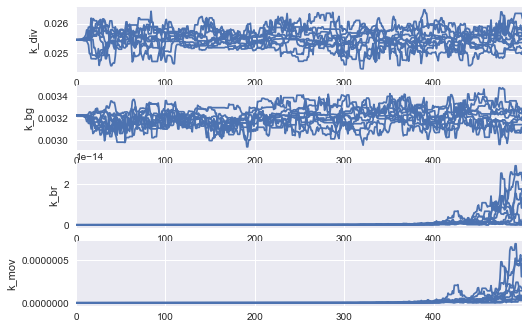

In [176]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_4x4, res.x, True)
print('Done')
plot_chain(sampler, True)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02542
k_bg = 0.00321
k_br = 0.00000
k_mov = 0.00000


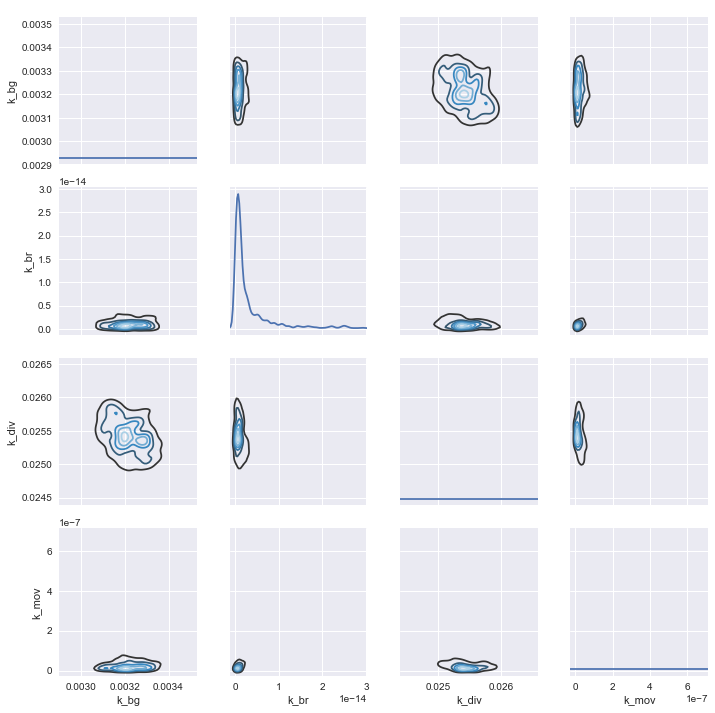

In [177]:
k_2x2_coupled = plot_kdes(sampler, True, burntime=400)

## 4 x 4 bins

In [178]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1,0.1])

res = op.leastsq(model.residual, x0, args=(bin_6x6, -0.15, 0.1, True))
res[0]

#res = op.least_squares(model.residual, x0, args=(bin_4x4, -0.15, 0.1, True), bounds=(0,np.inf), method='trf')
#res.x

array([ 0.02219682,  0.00257173,  0.00016294,  0.00021555])

CPU times: user 10.9 s, sys: 2.55 s, total: 13.5 s
Wall time: 8min 43s
Done


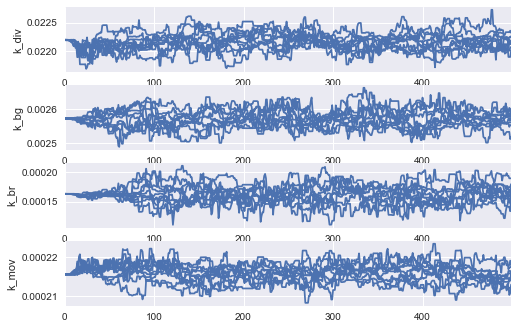

In [179]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_6x6, res[0], True)
print('Done')
plot_chain(sampler, True)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02219
k_bg = 0.00257
k_br = 0.00016
k_mov = 0.00022


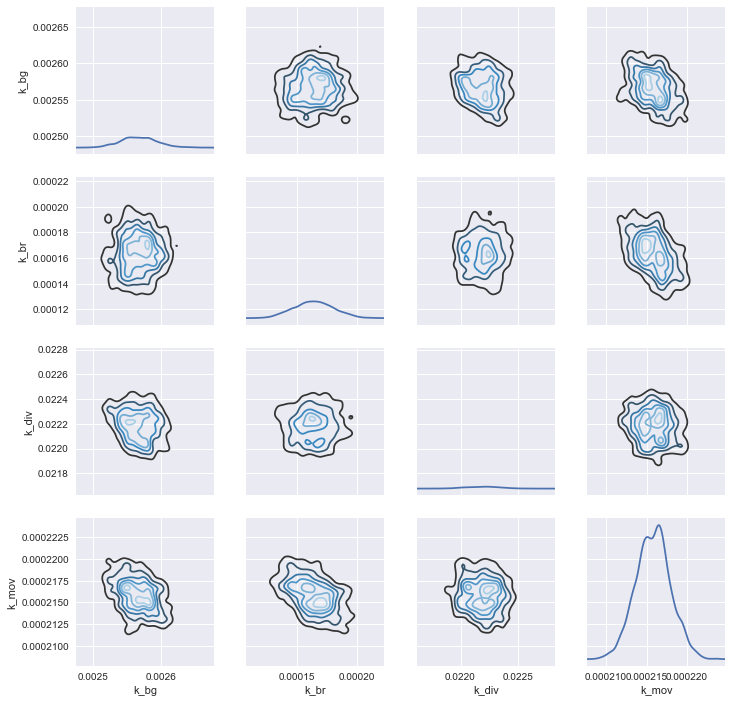

In [180]:
k_4x4_coupled = plot_kdes(sampler, True)

## 6 x 6 bins

In [181]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1,0.1])

res = op.leastsq(model.residual, x0, args=(bin_8x8, -0.15, 0.1, True))
res[0]

#res = op.least_squares(model.residual, x0, args=(bin_4x4, -0.15, 0.1, True), bounds=(0,np.inf), method='trf')
#res.x

array([ 0.02182581,  0.0011105 ,  0.00035238,  0.00048474])

CPU times: user 15.6 s, sys: 4.88 s, total: 20.5 s
Wall time: 16min 14s
Done


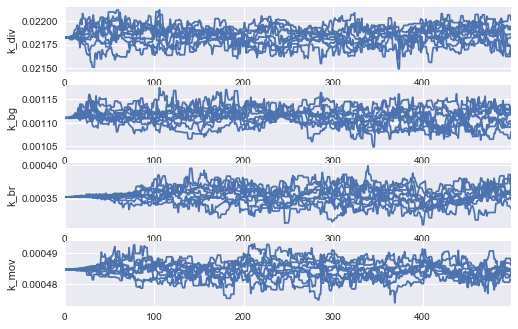

In [182]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_8x8, res[0], True)
print('Done')
plot_chain(sampler, True)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02185
k_bg = 0.00111
k_br = 0.00035
k_mov = 0.00048


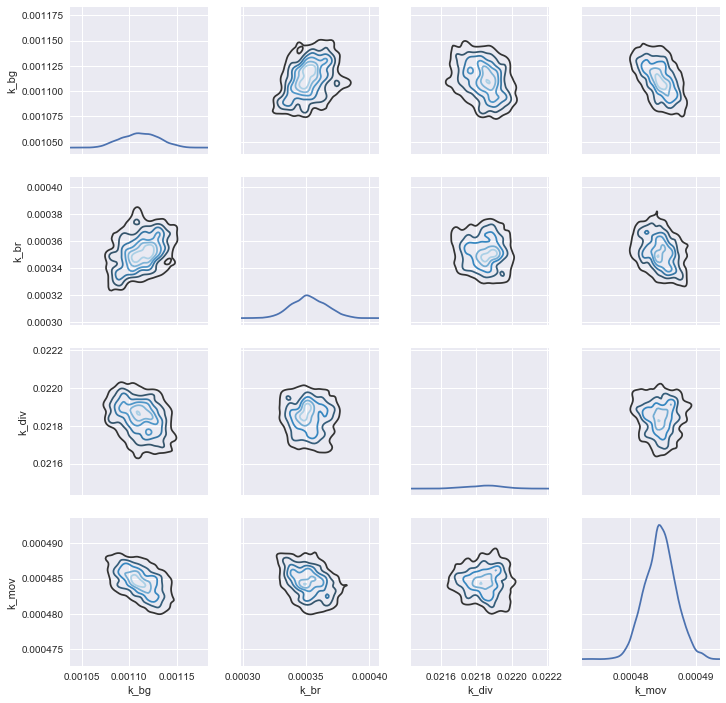

In [183]:
k_6x6_coupled = plot_kdes(sampler, True)

## 8x8 bins

In [6]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1,0.1])

#res = op.leastsq(model.residual, x0, args=(bin_10x10, -0.15, 0.1, True))
#res[0]

res = op.least_squares(model.residual, x0, args=(bin_10x10, -0.15, 0.1, True), bounds=(0,np.inf), method='trf')
res.x

array([  2.11688776e-02,   2.18712402e-03,   1.09423964e-18,
         5.57991435e-04])

CPU times: user 9.3 s, sys: 1.7 s, total: 11 s
Wall time: 24min 54s
Done


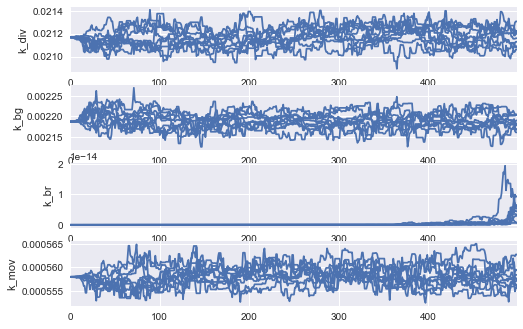

In [10]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_10x10, res.x, True)
print('Done')
plot_chain(sampler, True)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02119
k_bg = 0.00219
k_br = 0.00000
k_mov = 0.00056


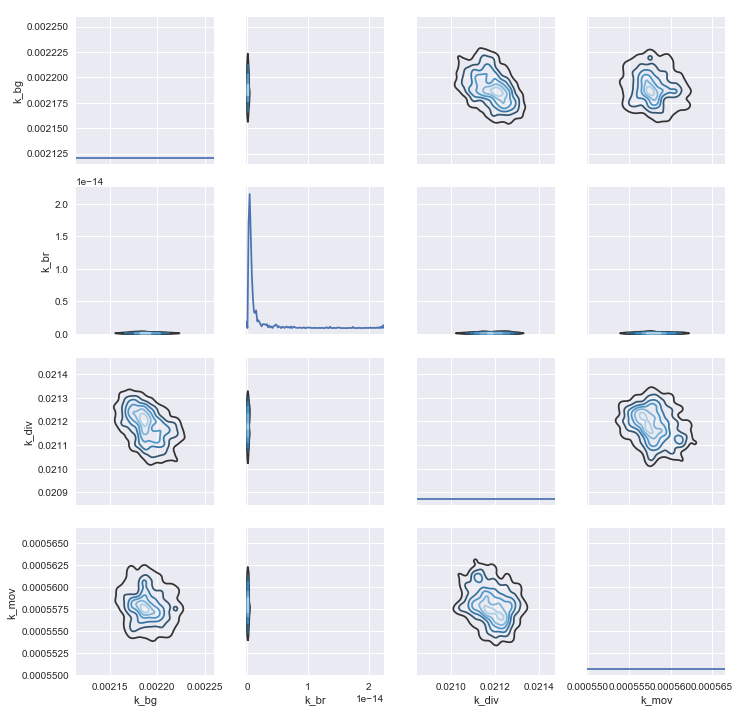

In [11]:
k_8x8_coupled = plot_kdes(sampler, True)

## 10 x 10 bins

In [12]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1,0.1])

res = op.leastsq(model.residual, x0, args=(bin_12x12, -0.15, 0.1, True))
res[0]

#res = op.least_squares(model.residual, x0, args=(bin_10x10, -0.15, 0.1, True), bounds=(0,np.inf), method='trf')
#res.x

array([ 0.02115077,  0.00279293,  0.00013236,  0.00061019])

Done


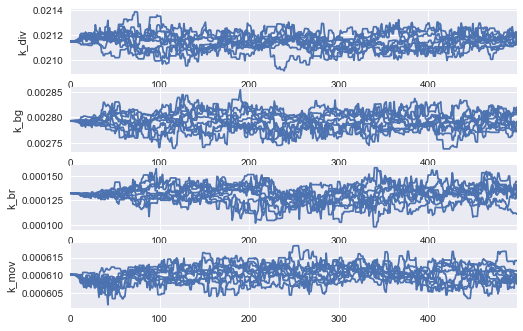

In [13]:
# Run the sampler.
sampler_10 = model.run_mcmc(bin_12x12, res[0], True)
print('Done')
plot_chain(sampler_10, True)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02115
k_bg = 0.00279
k_br = 0.00013
k_mov = 0.00061


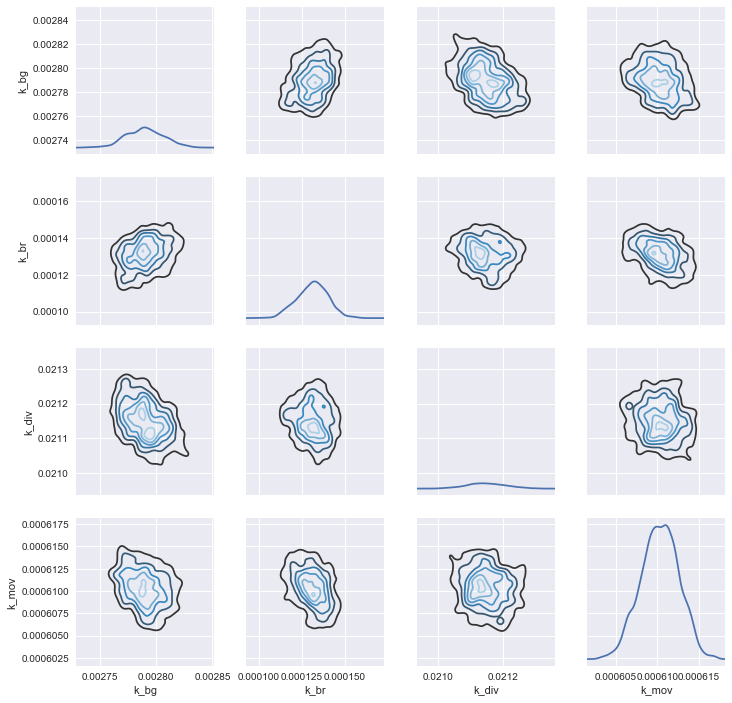

In [14]:
k_10x10_coupled = plot_kdes(sampler_10, True)

### Heatmaps for 10x10 bins

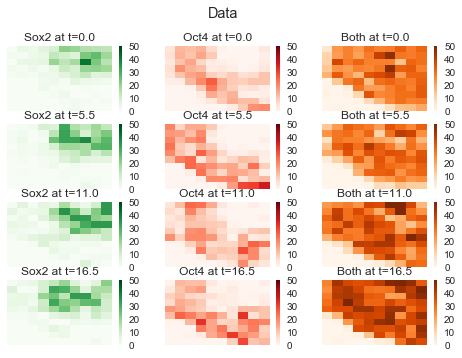

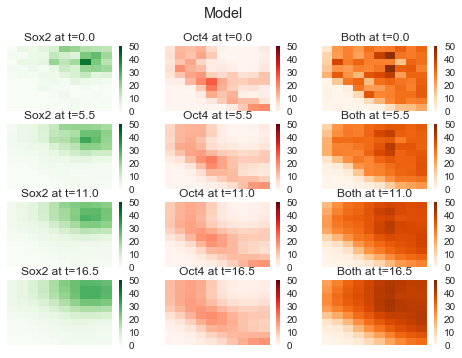

In [25]:
plot_heatmap(k_10x10_coupled, bin_12x12, True)

## 14 x 14 bins (just for checking purpose)

In [47]:
bin_16x16 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 16)

In [48]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1,0.1])

res = op.leastsq(model.residual, x0, args=(bin_16x16, -0.15, 0.1, True))
res[0]

array([ 0.02502909,  0.0042643 ,  0.00019569,  0.00097787])

CPU times: user 31 s, sys: 7.51 s, total: 38.5 s
Wall time: 5h 41min 25s
Done


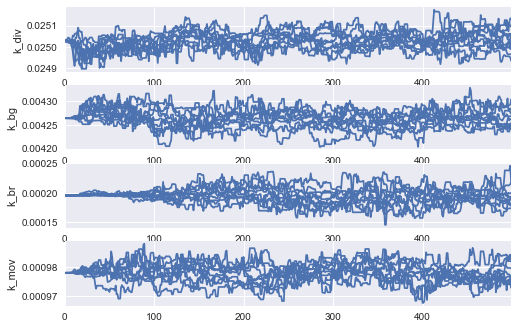

In [50]:
# Run the sampler.
%time sampler_14 = model.run_mcmc(bin_16x16, res[0], True)
print('Done')
plot_chain(sampler_14, True)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02503
k_bg = 0.00426
k_br = 0.00019
k_mov = 0.00098


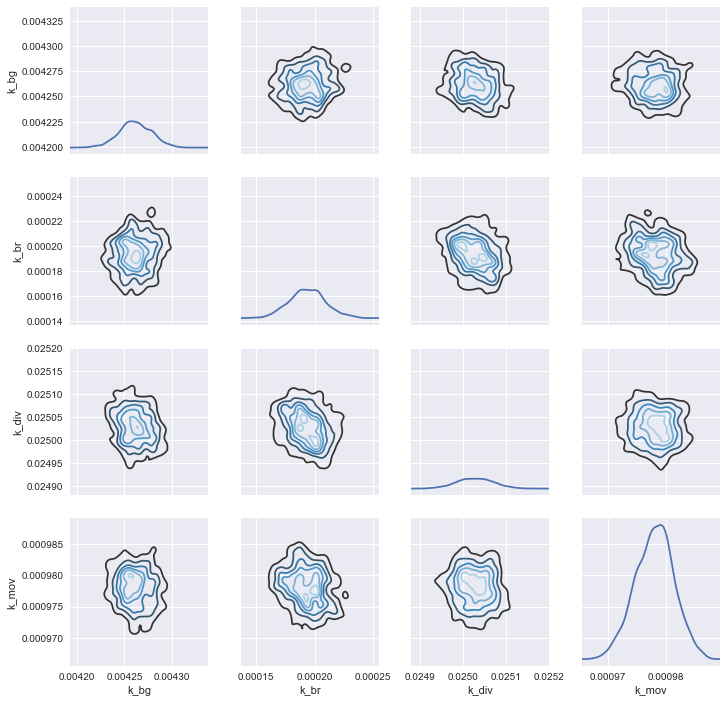

In [51]:
k_14x14_coupled = plot_kdes(sampler_14, True)

# No diffusion

Our likelihood function takes log of both data and model. While we exclude zero points data, there exist remaining zero points in this model which becomes troublesome. We first check the number of remaining zero points generated from this model. The number is small so we assume their contribution to be negligible.

In [55]:
x0 = np.array([0.1, 0.01, 0.01])

for i in range(10):
    test = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', (i+1)*2)
    m = model.solver_uncoupled(x0, test)
    y = test.pd2np()

    nonzero_args = np.nonzero(y)
    y = y[nonzero_args]
    m = m[nonzero_args]

    mzeros = len(np.where(m==0)[0])/len(m)
    print("For bin number %i, the fraction of remaining zeros in model is %.1f %%" %((i+1)*2, mzeros*100))

For bin number 2, the fraction of remaining zeros in model is 0.0 %
For bin number 4, the fraction of remaining zeros in model is 0.0 %
For bin number 6, the fraction of remaining zeros in model is 0.9 %
For bin number 8, the fraction of remaining zeros in model is 1.1 %
For bin number 10, the fraction of remaining zeros in model is 3.8 %
For bin number 12, the fraction of remaining zeros in model is 5.0 %
For bin number 14, the fraction of remaining zeros in model is 5.3 %
For bin number 16, the fraction of remaining zeros in model is 5.2 %
For bin number 18, the fraction of remaining zeros in model is 5.4 %
For bin number 20, the fraction of remaining zeros in model is 5.4 %


## 2 x 2 bins

In [146]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1])

#res = op.leastsq(model.residual, x0, args=(bin_2x2, -0.15, 0.1, False))
#res[0]

res = op.least_squares(model.residual, x0, args=(bin_2x2, -0.15, 0.1, False), bounds=(0,np.inf), method='trf')
res.x

array([  3.09206387e-02,   2.30999056e-03,   1.65043069e-19])

CPU times: user 10.5 s, sys: 544 ms, total: 11 s
Wall time: 25.3 s
Done


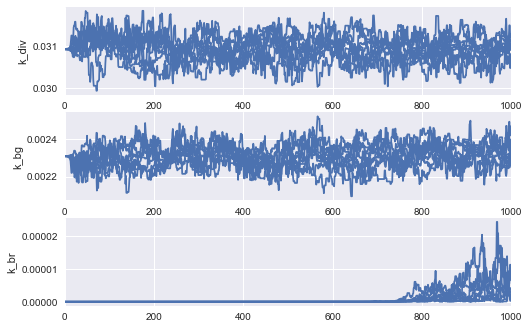

In [151]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_2x2, res.x, False, nsteps=1000)
print('Done')
plot_chain(sampler, False)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.03092
k_bg = 0.00232
k_br = 0.00000


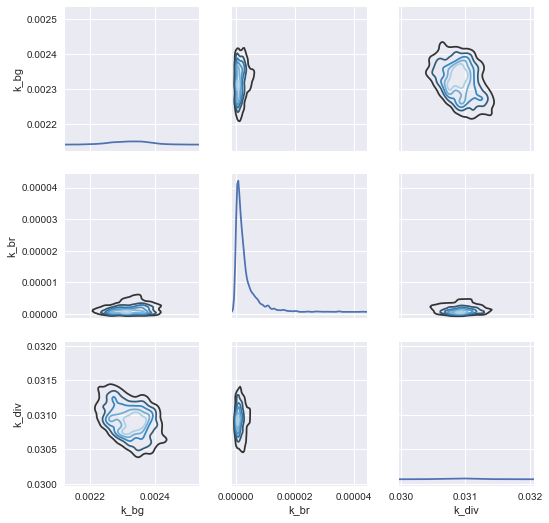

In [153]:
k_2x2_uncoupled = plot_kdes(sampler, False, burntime=800)

## 4x4 bins

In [163]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1])

res = op.leastsq(model.residual, x0, args=(bin_4x4, -0.15, 0.1, False))
res[0]

#res = op.least_squares(model.residual, x0, args=(bin_2x2, -0.15, 0.1, False), bounds=(0,np.inf), method='trf')
#res.x

array([ 0.02963265,  0.00385647,  0.00034337])

CPU times: user 7.34 s, sys: 538 ms, total: 7.88 s
Wall time: 39.2 s
Done


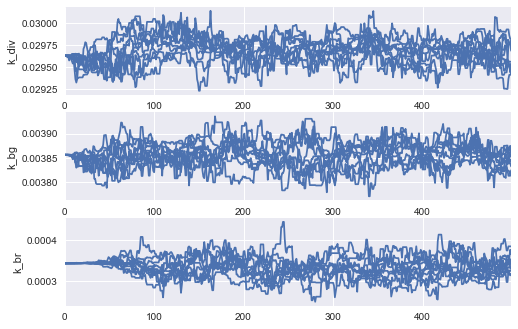

In [164]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_4x4, res[0], False)
print('Done')
plot_chain(sampler, False)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02972
k_bg = 0.00386
k_br = 0.00033


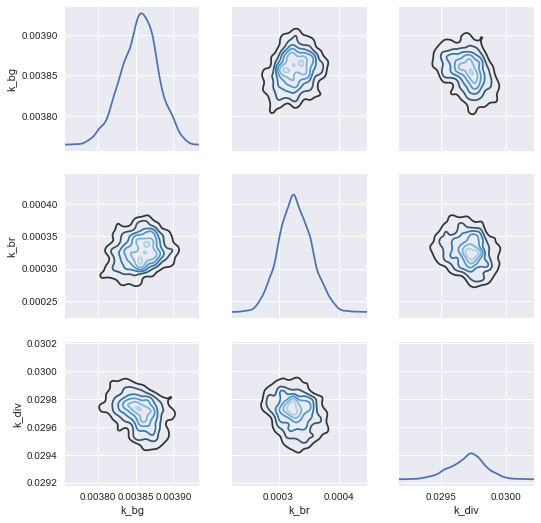

In [165]:
k_4x4_uncoupled = plot_kdes(sampler, False)

## 6 x 6 bins

In [166]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1])

res = op.leastsq(model.residual, x0, args=(bin_6x6, -0.15, 0.1, False))
res[0]

#res = op.least_squares(model.residual, x0, args=(bin_2x2, -0.15, 0.1, False), bounds=(0,np.inf), method='trf')
#res.x

array([ 0.02894024,  0.00490638,  0.00566657])

CPU times: user 7.7 s, sys: 829 ms, total: 8.53 s
Wall time: 1min 9s
Done


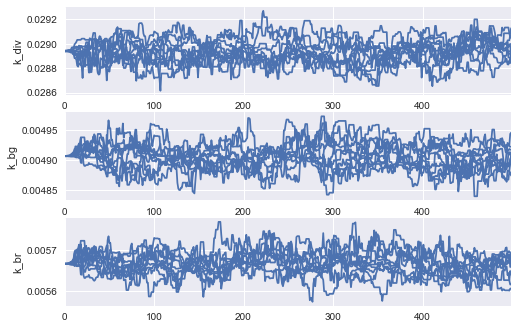

In [167]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_6x6, res[0], False)
print('Done')
plot_chain(sampler, False)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02894
k_bg = 0.00490
k_br = 0.00566


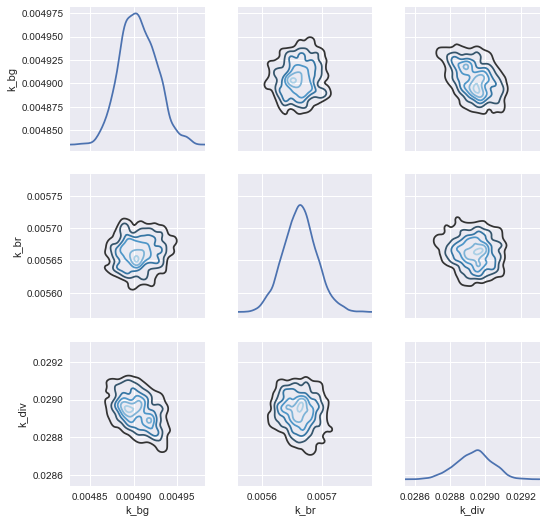

In [168]:
k_6x6_uncoupled = plot_kdes(sampler, False)

## 8 x 8 bins

In [120]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1])

res = op.leastsq(model.residual, x0, args=(bin_8x8, -0.15, 0.1, False))
res[0]

#res = op.least_squares(residual, x0, args=(testobject, -0.15, 0.1), bounds=(0,np.inf), method='trf')
#res.x

array([ 0.032312  ,  0.00387679,  0.01021472])

CPU times: user 8.9 s, sys: 919 ms, total: 9.82 s
Wall time: 2min 12s
Done


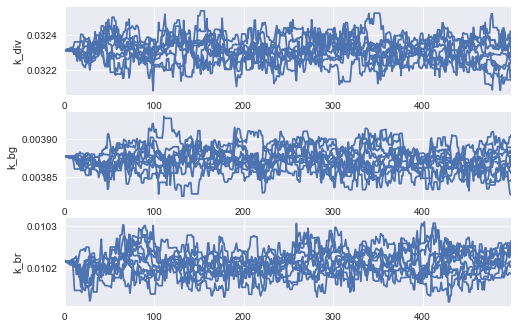

In [131]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_8x8, res[0], False)
print('Done')
plot_chain(sampler, False)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.03231
k_bg = 0.00387
k_br = 0.01021


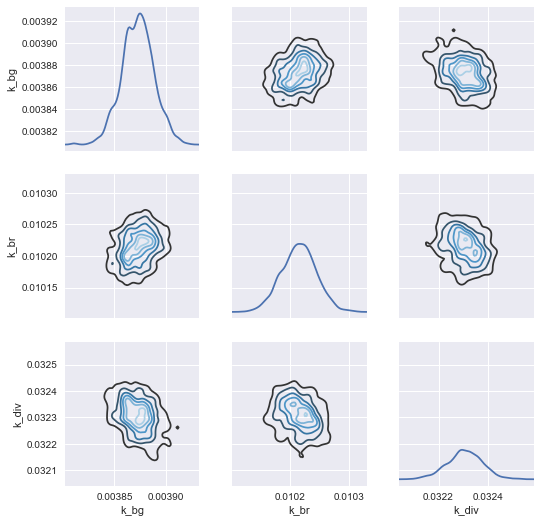

In [141]:
k_8x8_uncoupled = plot_kdes(sampler, False)

## 10 x 10 bins

In [169]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1])

res = op.leastsq(model.residual, x0, args=(bin_10x10, -0.15, 0.1, False))
res[0]

#res = op.least_squares(model.residual, x0, args=(bin_2x2, -0.15, 0.1, False), bounds=(0,np.inf), method='trf')
#res.x

array([ 0.02730428,  0.00557678,  0.01329759])

CPU times: user 9.77 s, sys: 1.51 s, total: 11.3 s
Wall time: 2min 57s
Done


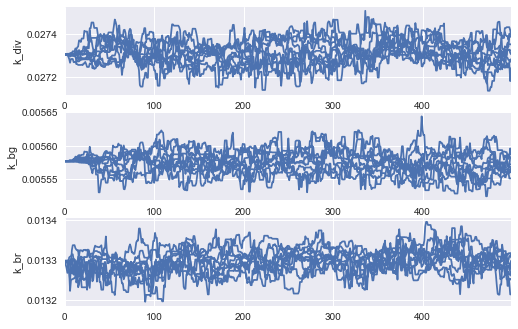

In [171]:
# Run the sampler.
%time sampler = model.run_mcmc(bin_10x10, res[0], False)
print('Done')
plot_chain(sampler, False)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02731
k_bg = 0.00557
k_br = 0.01330


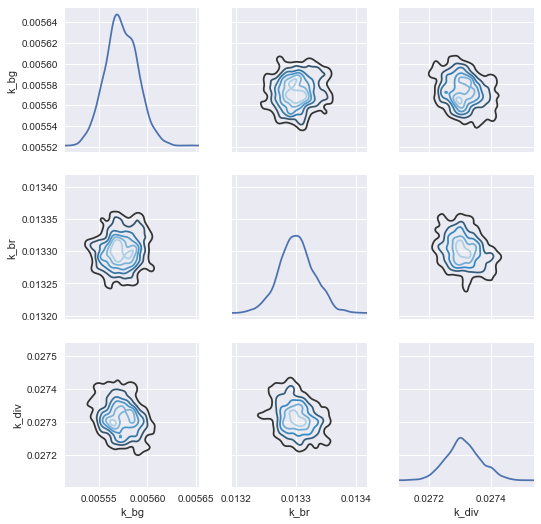

In [172]:
k_10x10_uncoupled = plot_kdes(sampler, False)

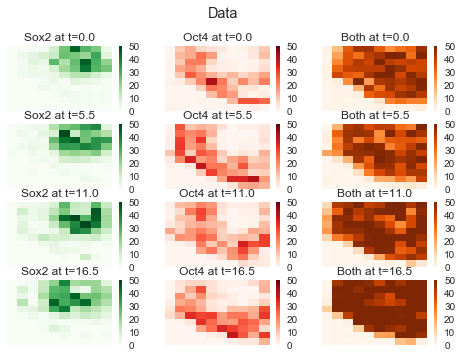

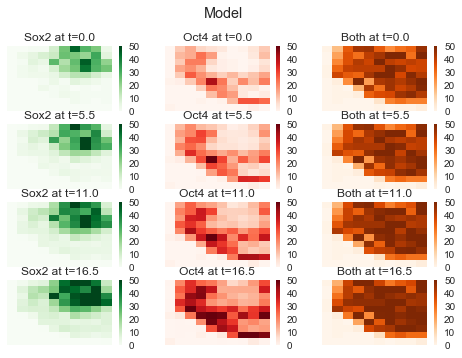

In [224]:
plot_heatmap(k_10x10_uncoupled, bin_10x10, False)

# Analysis

# Total number of cells

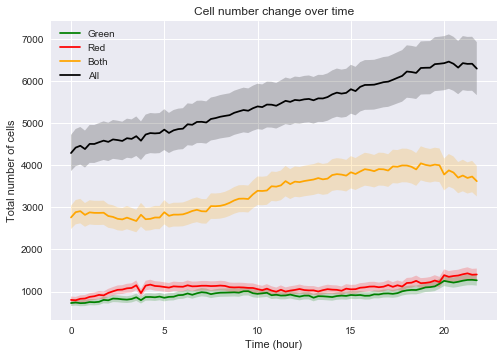

In [57]:
testobject=io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 1)

stepNum = int(testobject.tot_time)
M = np.zeros((4, stepNum))
for i in range(stepNum):
    M[0,i]=np.sum(testobject.pd2np()[0, :, :, i])
    M[1,i]=np.sum(testobject.pd2np()[1, :, :, i])
    M[2,i]=np.sum(testobject.pd2np()[2, :, :, i])
    M[3,i]=np.sum(testobject.pd2np()[:, :, :, i])

t = np.arange(stepNum)*.25
err = M*0.1
lower = M - err
upper = M + err
    
plt.plot(t, M[0], 'g', label='Green')
plt.fill_between(t, lower[0], upper[0], alpha=0.2, facecolor='g')

plt.plot(t, M[1], 'r', label='Red')
plt.fill_between(t, lower[1], upper[1], alpha=0.2, facecolor='r')

plt.plot(t, M[2], 'orange', label='Both')
plt.fill_between(t, lower[2], upper[2], alpha=0.2, facecolor='orange')

plt.plot(t, M[3], 'k', label='All')
plt.fill_between(t, lower[3], upper[3], alpha=0.2, facecolor='k')

plt.title('Cell number change over time')
plt.xlabel('Time (hour)')
plt.ylabel('Total number of cells')
plt.legend();

## Linear Fit for the total number of cells

To have the prior on the k values, we look at the general trend of cell numbers

Change of rate per cell is m/(initial cell number) = 0.023 (per hour)


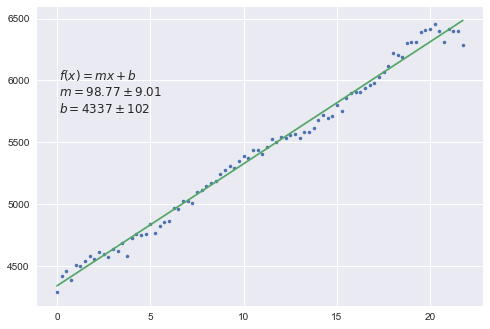

In [59]:
def linear(p, x):
    return p[0] + p[1]*x
linear_residual = lambda p, x, y, var: (y-linear(p, x))/var
p0 = [1., 1.]

result = op.leastsq(linear_residual, p0, args=(t, M[3], err[3]), full_output=1)

b, m = result[0]
b_var, m_var = np.sqrt(np.diagonal(result[1]))

plt.plot(t, M[3], '.')
plt.plot(t, linear([b, m], t))

ax = plt.axes()
textfit = '$f(x) = mx + b$ \n' \
          '$m = %.2f \pm %.2f$ \n' \
          '$b = %.0f \pm %.0f$ \n' \
          % (m, m_var, b, b_var)
ax.text(0.05, .80, textfit, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')


print("Change of rate per cell is m/(initial cell number) = %.3f (per hour)" % (m/M[3,0]))

So we expect our k values to be much smaller than 1, which we use as upper bound for the prior function.

## Summary of Results
### Scatter plot of k values for each bin number

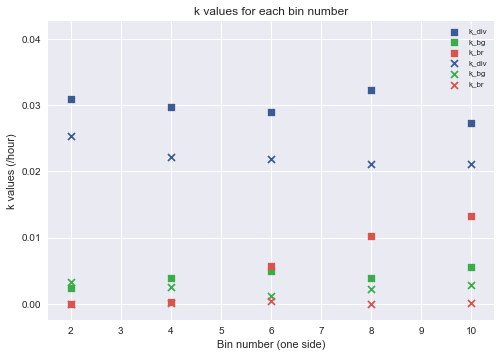

In [71]:
# Load data
K_coupled = np.loadtxt('K_coupled_save.txt')
K_uncoupled = np.loadtxt('K_uncoupled_save.txt')

# For model without diffusion
k_div_uncoupled = K_uncoupled.T[0]
k_bg_uncoupled = K_uncoupled.T[1]
k_br_uncoupled = K_uncoupled.T[2]

x = (np.arange(5)+1)*2
plt.scatter(x, k_div_uncoupled, c=sns.xkcd_rgb["denim blue"], label='k_div', marker="s")
plt.scatter(x, k_bg_uncoupled, c=sns.xkcd_rgb["medium green"], label='k_bg', marker="s")
plt.scatter(x, k_br_uncoupled, c=sns.xkcd_rgb["pale red"], label='k_br', marker="s")

# For model with diffusion
k_div_coupled = K_coupled.T[0]
k_bg_coupled = K_coupled.T[1]
k_br_coupled = K_coupled.T[2]
k_mov_coupled = K_coupled.T[3]

plt.scatter(x, k_div_coupled, c=sns.xkcd_rgb["denim blue"], label='k_div', marker="x")
plt.scatter(x, k_bg_coupled, c=sns.xkcd_rgb["medium green"], label='k_bg', marker="x")
plt.scatter(x, k_br_coupled, c=sns.xkcd_rgb["pale red"], label='k_br', marker="x")

plt.legend(loc=1,prop={'size':8})
plt.xlabel('Bin number (one side)')
plt.ylabel('k values (/hour)')
plt.title('k values for each bin number')

If we include $k_{mov}$ in the plot (note that it has different dimension),

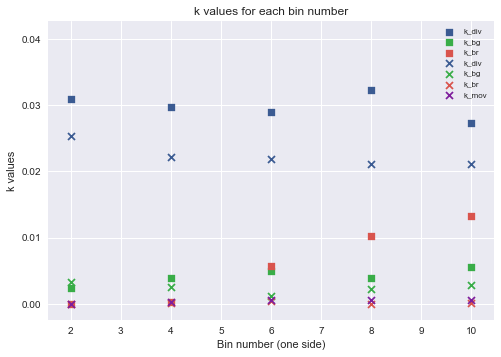

In [73]:
plt.scatter(x, k_div_uncoupled, c=sns.xkcd_rgb["denim blue"], label='k_div', marker="s")
plt.scatter(x, k_bg_uncoupled, c=sns.xkcd_rgb["medium green"], label='k_bg', marker="s")
plt.scatter(x, k_br_uncoupled, c=sns.xkcd_rgb["pale red"], label='k_br', marker="s")

plt.scatter(x, k_div_coupled, c=sns.xkcd_rgb["denim blue"], label='k_div', marker="x")
plt.scatter(x, k_bg_coupled, c=sns.xkcd_rgb["medium green"], label='k_bg', marker="x")
plt.scatter(x, k_br_coupled, c=sns.xkcd_rgb["pale red"], label='k_br', marker="x")
plt.scatter(x, k_mov_coupled, c=sns.xkcd_rgb["purple"], label='k_mov', marker="x")

plt.legend(loc=1,prop={'size':8})
plt.xlabel('Bin number (one side)')
plt.ylabel('k values')
plt.title('k values for each bin number')

#### Additional code for storing data (not important)

In [66]:
data_K_uncoupled = pd.DataFrame(data={'k_div': K_uncoupled.T[0],
                                 'k_bg': K_uncoupled.T[1],
                                 'k_br': K_uncoupled.T[2]},
                               index=[2, 4, 6, 8, 10])
data_K_uncoupled=data_K_uncoupled[['k_div', 'k_bg', 'k_br']]

data_K_coupled = pd.DataFrame(data={'k_div': K_coupled.T[0],
                                 'k_bg': K_coupled.T[1],
                                 'k_br': K_coupled.T[2],
                                   'k_mov': K_coupled.T[3]},
                               index=[2, 4, 6, 8, 10])
data_K_coupled=data_K_coupled[['k_div', 'k_bg', 'k_br', 'k_mov']]

data_K_coupled.to_csv('K_coupled_save')
data_K_uncoupled.to_csv('K_uncoupled_save')